# Reconhecimento de Padrões (TIP8311) - Trabalho 2


**Professor:** Guilherme de Alencar Barreto  

<img src="https://loop.frontiersin.org/images/profile/243428/203" alt="Foto do Professor" width="150"/>


**Aluno:** Luis Felipe Carneiro de Souza    **Matrícula:** 535049

In [1]:
import pandas as pd
import numpy as np
import time
from scipy.spatial.distance import minkowski
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

In [2]:
paht_sensor_4 = "https://raw.githubusercontent.com/LuisFelipeCSouza/reconhecimento-de-padroes/refs/heads/main/trabalho-2/wall%2Bfollowing%2Brobot%2Bnavigation%2Bdata/sensor_readings_4.data"

path_sensor_24 = "https://raw.githubusercontent.com/LuisFelipeCSouza/reconhecimento-de-padroes/refs/heads/main/trabalho-2/wall%2Bfollowing%2Brobot%2Bnavigation%2Bdata/sensor_readings_24.data"

A flag `opt = 1` em *`cov(x, opt)`* normaliza com N

```octave
>> format long g
>> cov(X, 1)
ans =

 Columns 1 and 2:

      0.3926803582086445   -0.006142993532974544
   -0.006142993532974544      0.1173492953591072
     -0.0362831756885664    -0.03929951736012198
      -0.112023079916189     0.09336558416015139

 Columns 3 and 4:

     -0.0362831756885664      -0.112023079916189
    -0.03929951736012198     0.09336558416015139
      0.3163850369731714    -0.01816601865718874
    -0.01816601865718874      0.6751499405340027
```

In [3]:
M_ref = np.array([
    [ 0.3926803582086445,  -0.006142993532974544,  -0.0362831756885664,  -0.112023079916189 ],
    [ -0.006142993532974544,  0.1173492953591072,  -0.03929951736012198,   0.09336558416015139 ],
    [ -0.0362831756885664,  -0.03929951736012198,   0.3163850369731714,  -0.01816601865718874 ],
    [ -0.112023079916189,   0.09336558416015139,  -0.01816601865718874,   0.6751499405340027 ]
])
print(M_ref)

[[ 0.39268036 -0.00614299 -0.03628318 -0.11202308]
 [-0.00614299  0.1173493  -0.03929952  0.09336558]
 [-0.03628318 -0.03929952  0.31638504 -0.01816602]
 [-0.11202308  0.09336558 -0.01816602  0.67514994]]


In [4]:
data = np.genfromtxt(paht_sensor_4, delimiter=",", dtype=str, encoding="utf-8")

X = data[:, :-1].astype(float)  # todas menos a última coluna convertidas para float
y = data[:, -1]                 # última coluna como string

y = y.reshape(-1, 1)

X, y

(array([[1.687, 0.445, 2.332, 0.429],
        [1.687, 0.449, 2.332, 0.429],
        [1.687, 0.449, 2.334, 0.429],
        ...,
        [0.873, 0.642, 1.053, 1.105],
        [0.967, 0.635, 1.034, 1.118],
        [0.854, 0.628, 1.016, 1.168]]),
 array([['Slight-Right-Turn'],
        ['Slight-Right-Turn'],
        ['Slight-Right-Turn'],
        ...,
        ['Sharp-Right-Turn'],
        ['Move-Forward'],
        ['Sharp-Right-Turn']], dtype='<U17'))

## Q1.

Estimar a matriz de covariância GLOBAL (i.e. sem considerar os rótulos das classes) para o referido conjunto de dados usando os Métodos 1 a 4 descritos nos slides. Comparar como o resultado produzido pelo comando COV nativo Octave/Matlab ou de outra de programação de sua preferência. Para a comparação, calcular a norma da matriz de diferenças &E = C - C& em que C é matriz de covariância estimada pelos métodos implementados  C é a matrz

Método 1

In [5]:
Rx = np.corrcoef(X, rowvar=False)

mu = X.mean(axis=0)

Cx = Rx - mu.T @ mu
Cx

array([[-6.29254432, -7.32116107, -7.3954828 , -7.51010871],
       [-7.32116107, -6.29254432, -7.49650151, -6.96084357],
       [-7.3954828 , -7.49650151, -6.29254432, -7.33184967],
       [-7.51010871, -6.96084357, -7.33184967, -6.29254432]])

Método 1

In [6]:
def cov_1(X):
    p, N = X.shape
    soma = np.zeros((p, p))
    m = X.mean(axis=1).reshape(-1,1) # Vetor coluna
    for i in range(N):
        aux = X[:, i].reshape(-1, 1) - m
        soma += aux @ aux.T
    C = soma / N
    return C

In [7]:
cov_1(X.T)

array([[ 0.39268036, -0.00614299, -0.03628318, -0.11202308],
       [-0.00614299,  0.1173493 , -0.03929952,  0.09336558],
       [-0.03628318, -0.03929952,  0.31638504, -0.01816602],
       [-0.11202308,  0.09336558, -0.01816602,  0.67514994]])

Método 2

In [8]:
def cov_2(X):
    p, N = X.shape
    m = X.mean(axis=1).reshape(-1,1) # Vetor coluna
    aux = X - m
    return (aux @ aux.T) / N

In [9]:
cov_2(X.T)

array([[ 0.39268036, -0.00614299, -0.03628318, -0.11202308],
       [-0.00614299,  0.1173493 , -0.03929952,  0.09336558],
       [-0.03628318, -0.03929952,  0.31638504, -0.01816602],
       [-0.11202308,  0.09336558, -0.01816602,  0.67514994]])

Método 3

In [10]:
def cov_3(X):
    p, N = X.shape
    R = np.zeros((p, p))
    m = X.mean(axis=1).reshape(-1,1)
    for i in range(N):
        R += X[:, i].reshape(-1, 1) @ X[:, i].reshape(-1, 1).T

    C = (R / N) - (m @ m.T)
    return C

In [11]:
cov_3(X.T)

array([[ 0.39268036, -0.00614299, -0.03628318, -0.11202308],
       [-0.00614299,  0.1173493 , -0.03929952,  0.09336558],
       [-0.03628318, -0.03929952,  0.31638504, -0.01816602],
       [-0.11202308,  0.09336558, -0.01816602,  0.67514994]])

Método 4

In [12]:
def cov_4(X):
    p, N = X.shape
    m = X.mean(axis=1).reshape(-1,1)
    R = (X @ X.T) / N
    C = R - (m @ m.T)
    return C

In [13]:
cov_4(X.T)

array([[ 0.39268036, -0.00614299, -0.03628318, -0.11202308],
       [-0.00614299,  0.1173493 , -0.03929952,  0.09336558],
       [-0.03628318, -0.03929952,  0.31638504, -0.01816602],
       [-0.11202308,  0.09336558, -0.01816602,  0.67514994]])

## Questão 02

Comparar (de modo cientficamente correto!) os métodos implementados no Item 1 com o comando COV nativo do Octave/Matlab ou de outra linguagem de programação que melhor lhe convier em termos de tempo médio de execução. No Matlab/Octave usar os comandos tic/toc. Para isso, execute cada método por 100 rodadas, guardando o tempo de execução de cada método em cada rodada. Ao final das 100 rodadas, compare os gráficos do histograma e do violin plot1 do tempo de execução de cada método. Compare-os também numericamente em termos de tempo de execução médio e desvio-padrão. Comente os resultados obtidos.

In [14]:
import time

# Supondo que você já tenha definido suas funções:
# def cov_1(X): ...
# def cov_2(X): ...
# def cov_3(X): ...
# def cov_4(X): ...

def simu(X, funcs, n_iter=100):
    """
    Executa n_iter rodadas de cálculo da matriz de covariância
    para cada função em funcs e retorna listas de tempos.
    
    X: matriz de entrada
    funcs: lista de funções [cov_1, cov_2, cov_3, cov_4]
    n_iter: número de repetições
    """
    tempos = [[] for _ in funcs]  # cria uma lista de listas

    for i, f in enumerate(funcs):
        for _ in range(n_iter):
            inicio = time.perf_counter()
            f(X.T)   # executa a função
            fim = time.perf_counter()
            tempos[i].append(fim - inicio)

    return tempos

# Exemplo de uso:
funcs = [cov_1, cov_2, cov_3, cov_4]
temp_cov_1, temp_cov_2, temp_cov_3, temp_cov_4 = simu(X, funcs, n_iter=100)

# tempos[0] = lista de tempos do cov_1
# tempos[1] = lista de tempos do cov_2
# etc.
temp_cov_1, temp_cov_2, temp_cov_3, temp_cov_4


([0.03805390000343323,
  0.03418769998825155,
  0.01835720002418384,
  0.024012700014282018,
  0.020563600002788007,
  0.02012010000180453,
  0.017847700015408918,
  0.01821510001900606,
  0.0191865999950096,
  0.018593000015243888,
  0.028327600011834875,
  0.021832000027643517,
  0.02009629999520257,
  0.019828999997116625,
  0.020623299991711974,
  0.026075900008436292,
  0.03314899999531917,
  0.03330149999237619,
  0.021397799981059507,
  0.020537300006253645,
  0.019230399979278445,
  0.019653900002595037,
  0.040263499977299944,
  0.02084449998801574,
  0.018733000004431233,
  0.018815500021446496,
  0.019134100002702326,
  0.018699899985222146,
  0.02005510000162758,
  0.019529699988197535,
  0.018639699992490932,
  0.024411499995039776,
  0.02552209998248145,
  0.08409830002347007,
  0.04803030000766739,
  0.04159129998879507,
  0.02048310000100173,
  0.019760800001677126,
  0.020412899990333244,
  0.019044000015128404,
  0.018539000011514872,
  0.018495600001187995,
  0.02141

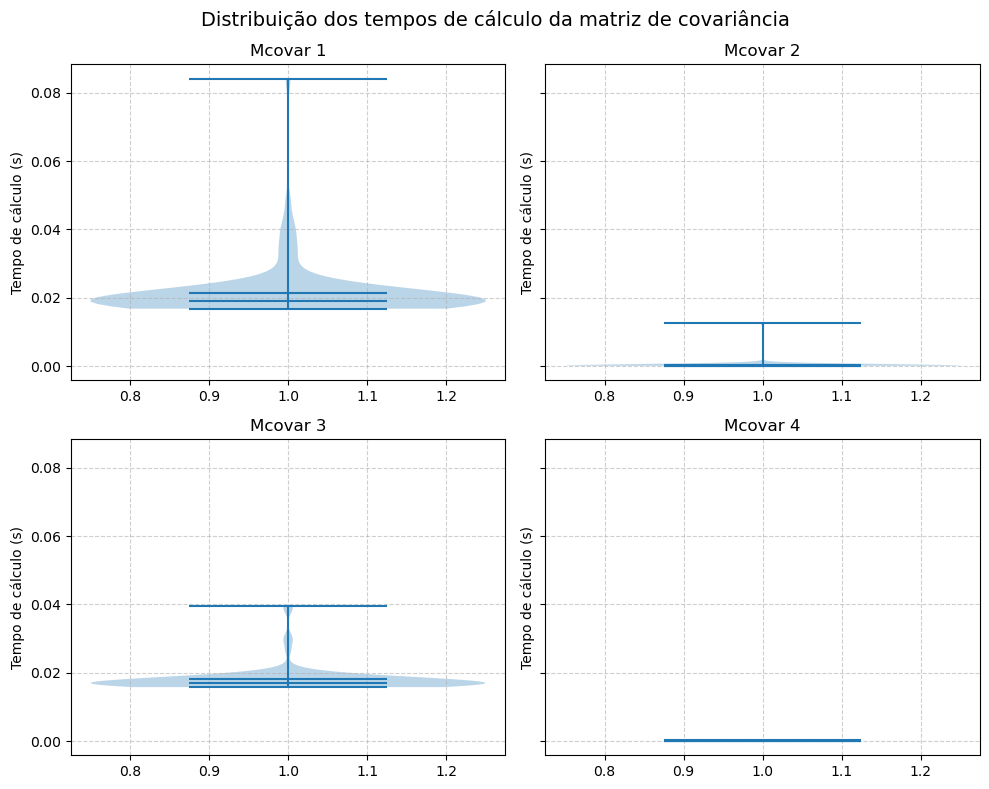

In [15]:
import matplotlib.pyplot as plt

# Supondo que você já tenha as listas:
# temp_cov_1 = [...]
# temp_cov_2 = [...]
# temp_cov_3 = [...]
# temp_cov_4 = [...]

data = [temp_cov_1, temp_cov_2, temp_cov_3, temp_cov_4]
labels = ["Mcovar 1", "Mcovar 2", "Mcovar 3", "Mcovar 4"]

fig, axes = plt.subplots(2, 2, figsize=(10,8), sharey=True)  # 2 linhas, 2 colunas
axes = axes.flatten()  # transformar em lista para iterar

for i, ax in enumerate(axes):
    ax.violinplot(data[i], showmeans=True, showmedians=True)
    ax.set_title(labels[i])
    ax.set_ylabel("Tempo de cálculo (s)")
    ax.grid(True, linestyle="--", alpha=0.6)

plt.suptitle("Distribuição dos tempos de cálculo da matriz de covariância", fontsize=14)
plt.tight_layout()
plt.show()


## Questão 03

Escolher o método mais rápido no Item 1 e estimar as matrizes de covariância de cada classe, avaliando suas invertibilidades comparando com a invertibilidade da matriz de covariância global através do posto e do número de condicionamento. No Matlab/Octave usar comandos rank e rcond. As matrizes em questão são invertíveis e numericamente bem-condicionadas?

In [22]:
X[:10, :]

array([[1.687, 0.445, 2.332, 0.429],
       [1.687, 0.449, 2.332, 0.429],
       [1.687, 0.449, 2.334, 0.429],
       [1.687, 0.449, 2.334, 0.429],
       [1.687, 0.449, 2.334, 0.429],
       [1.686, 0.446, 2.334, 0.43 ],
       [1.684, 0.451, 2.33 , 0.432],
       [1.68 , 0.453, 2.327, 0.436],
       [0.753, 0.457, 2.323, 0.442],
       [0.744, 0.462, 2.321, 0.449]])

In [27]:
np.unique(y, return_counts=True)


for i in np.unique(y):
    mask = np.where(y == i)[0] # mascara dos indices
    # print((np.where(y == i))[0])
    # print(X[(np.where(y == i))[0], :])

    y_class = y[mask]
    X_class = X[mask, :]
    print(f"Classe: {i}, Matriz de covariância:")
    print(cov_4(X_class.T), '\n')

Classe: Move-Forward, Matriz de covariância:
[[ 0.4677022  -0.00162651 -0.0646883  -0.11122701]
 [-0.00162651  0.00897263 -0.00546328  0.00755037]
 [-0.0646883  -0.00546328  0.28296953  0.04786369]
 [-0.11122701  0.00755037  0.04786369  0.34130193]] 

Classe: Sharp-Right-Turn, Matriz de covariância:
[[ 5.39462607e-03  4.23760936e-04 -6.83570516e-03 -4.25721561e-03]
 [ 4.23760936e-04  1.09053004e-01 -4.92398242e-02  8.22374161e-02]
 [-6.83570516e-03 -4.92398242e-02  4.48505192e-01 -5.39085397e-02]
 [-4.25721561e-03  8.22374161e-02 -5.39085397e-02  1.12071643e+00]] 

Classe: Slight-Left-Turn, Matriz de covariância:
[[ 0.10489945 -0.00764646  0.06755705 -0.0885949 ]
 [-0.00764646  0.27480251 -0.02828925  0.03960111]
 [ 0.06755705 -0.02828925  0.09801354 -0.06412424]
 [-0.0885949   0.03960111 -0.06412424  0.20613506]] 

Classe: Slight-Right-Turn, Matriz de covariância:
[[ 0.2812897  -0.00223476 -0.03581292 -0.00799291]
 [-0.00223476  0.00160667 -0.00519406  0.00123762]
 [-0.03581292 -0.005